# Part 1 - Estimate the value function for each  state by

In [2]:
import numpy as np
import cvxpy as cp
from grid_world import Grid_1 as ENV

# Plotting Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

## Helper Functions

In [3]:
def plot_value_function(V_pi_1, N=5, title="Value Function (0,0 at top-left)"):
    """
    Plots the value function with (0,0) at the top-left corner of the grid.
    Axis labels and displayed values match this layout.
    """
    # Reshape and flip the grid vertically to match (0,0) at top-left
    V_grid = np.flipud(V_pi_1.reshape(N, N))  # Flip rows

    # Create the plot
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(V_grid, annot=True, fmt=".3f", cmap="coolwarm", cbar=True,
                     linewidths=0.5, linecolor='black', square=True)

    # Invert y-axis to place row 0 at the top visually
    ax.invert_yaxis()

    # Set axis ticks and labels
    ax.set_xticks(np.arange(N) + 0.5)
    ax.set_yticks(np.arange(N) + 0.5)
    ax.set_xticklabels(np.arange(N))               # Column 0 on the left
    ax.set_yticklabels(np.arange(N)[::-1], rotation=0)  # Row 0 on top

    # Set title and layout
    plt.title(title)
    plt.tight_layout()
    plt.show()

## 1.1 **Solving the Bellman Equation Explicitly**

In [4]:
"""
Solves the Bellman equations to compute the state-value function for a given policy.

Args:
    gamma (float): Discount factor for future rewards (0 ≤ gamma ≤ 1)
    policy (ndarray): Stochastic policy matrix of shape (n_states, n_actions) 
                      where each row sums to 1 (probability distribution over actions)
    env (object): Environment object with:
        - number_of_states (int): Total number of states
        - number_of_actions (int): Number of possible actions
        - model (ndarray): Transition dynamics tensor of shape (number_of_states, number_of_actions, n_transitions, 3)
                          Each entry contains:
                          [0]: p - Transition probability (sums to 1 for each state-action pair)
                          [1]: s_ - Next state index
                          [2]: r - Immediate reward

Returns:
    ndarray: State-value function V^π of shape (n_states,) where each element 
             represents the expected return starting from that state, following π
"""
def Bellman_equation(gamma, policy, env):
    # Solve the linear system: Coeff_Matrix * Value_Function = Reward_Vector
    Coeff_Matrix = np.zeros([env.number_of_states, env.number_of_states])
    Reward_Vector = np.zeros(env.number_of_states)

    for state in range(env.number_of_states):  # iterate through each state
        Coeff_Matrix[state, state] = 1  # value function equation has VF[state] on the left
        for action in range(env.number_of_actions):  # iterate through each action
            for prob, next_state, reward in env.model[state][action]:  # transition model: (probability, next_state, reward)
                # Move the discounted future value terms to the left-hand side
                Coeff_Matrix[state, next_state] -= policy[state, action] * prob * gamma
                # Accumulate expected immediate reward on the right-hand side
                Reward_Vector[state] += policy[state, action] * prob * reward

    # Solve for Value_Function: VF = inverse(Coeff_Matrix) * Reward_Vector
    if np.linalg.det(Coeff_Matrix) == 0:
        raise ValueError("Coefficient matrix is singular; cannot compute inverse")

    Value_Function = np.dot(np.linalg.inv(Coeff_Matrix), Reward_Vector)
    return Value_Function

## 1.2 **Iterative Policy Evaluation**

In [5]:
"""
Performs iterative policy evaluation to estimate the state-value function V^π.

Computes the value function for a given policy by iteratively applying Bellman
expectation equations until convergence.

Args:
    theta (float): Convergence threshold (> 0). Smaller values yield more accurate
                  estimates. Evaluation stops when value changes are < theta.
    gamma (float): Discount factor (0 ≤ gamma ≤ 1) for future rewards.
    policy (ndarray): Policy matrix of shape [n_states, n_actions] where each row
                     is a probability distribution over actions (sums to 1).
    env (object): Environment with:
        - number_of_states (int): Total number of states
        - number_of_actions (int): Number of possible actions
        - model (ndarray): Transition model tensor of shape [number_of_states, number_of_actions, n_transitions, 3]:
                          [..., 0]: p - Transition probability (∑p = 1 per state-action)
                          [..., 1]: s_ - Next state index
                          [..., 2]: r - Immediate reward

Returns:
    ndarray: Converged value function V^π of shape [n_states], where each element
             represents the expected discounted return from that state under π.
"""
def Iterative_policy_evaluation(threshold, gamma, policy, env):
    state_values = np.zeros(env.number_of_states)  # Initialize value function for all states

    while True:
        max_change = 0  # Reset maximum change tracker

        for state in range(env.number_of_states):  # Loop through each state
            old_value = state_values[state]  # Save the previous value for comparison

            new_value = 0
            for action in range(env.number_of_actions):  # Loop through each possible action
                for transition_prob, next_state, reward in env.model[state][action]:
                    # Compute expected value based on policy, transition probability, reward, and next state's value
                    new_value += policy[state, action] * transition_prob * (reward + gamma * state_values[next_state])

            state_values[state] = new_value  # Update value for the current state

            max_change = max(max_change, abs(old_value - new_value))  # Track the largest change

        # Stop if the maximum change across all states is less than the convergence threshold
        if max_change < threshold:
            return state_values

## Part 1 **Results**

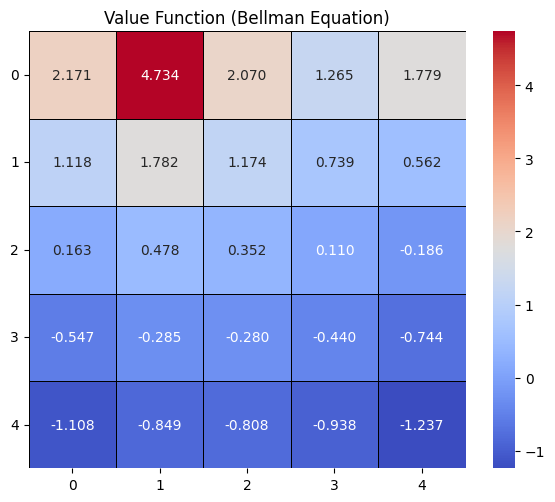

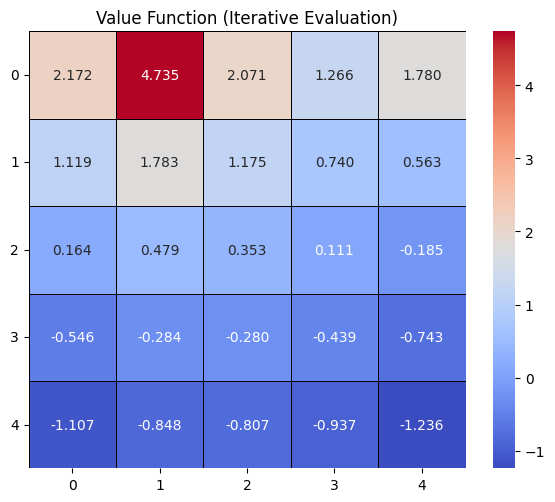

In [7]:
# Initialize the environment, set up parameters
the = 1e-4
gam = 0.95
Env = ENV()
pol = np.ones([Env.number_of_states, Env.number_of_actions]) / Env.number_of_actions  # initialize policy, the sum of each row is 1

# Calculate the value function via the three approaches
V_pi_1 = Bellman_equation(gam, pol, Env)
V_pi_2 = Iterative_policy_evaluation(the, gam, pol, Env)

# Plot the value function obtained from Bellman equation
plot_value_function(V_pi_1, N=int(np.sqrt(Env.number_of_states)), 
                                    title="Value Function (Bellman Equation)")

# Plot the value function obtained from iterative policy evaluation
plot_value_function(V_pi_2, N=int(np.sqrt(Env.number_of_states)), 
                                    title="Value Function (Iterative Evaluation)")

# Part 2 - Determining optimal policy for the gridworld problem by

## Helper functions

In [9]:
"""
Computes the optimal policy given a value function using policy improvement.

Args:
    gamma (float): Discount factor for future rewards (0 ≤ gamma ≤ 1)
    V (ndarray): Current value function array of shape (number_of_states,)
    env (object): Environment containing:
        - number_of_states (int): Total number of states
        - number_of_actions (int): Number of possible actions
        - model (ndarray): Transition model array of shape 
                         (number_of_states, number_of_actions, n, 3) where:
                         [..., 0]: p - Transition probability (∑p = 1)
                         [..., 1]: s_ - Next state index
                         [..., 2]: r - Immediate reward

Returns:
    list: Optimal policy where each element is a list of optimal actions for that state.
          Format: [state][action_indices] where action_indices may contain multiple
          equally-good actions.
"""
def find_policy(gamma, V, env):
    pol = [[0] for _ in range(env.number_of_states)]  # initialize a deterministic policy

    for s in range(env.number_of_states):  # iterate through all the states in the state space
        temp1 = []
        for a in range(env.number_of_actions):  # iterate through all the actions in the action space
            temp2 = 0
            for p, s_, r in env.model[s][a]:  # iterate through all the possibilities in model
                temp2 += p * (r + gamma * V[s_])
            temp1.append(temp2)
                
        pol[s] = (np.unique(np.argwhere(temp1 == np.max(temp1)))).tolist()  # find the optimal policy under the current value function
        
    return pol

"""
    Plots a 5x5 grid with centered symbols, colored overlays on specific cells.
    (0,0) is top-left. Colors: (0,1)=blue, (0,4)=green, (4,2)=red, (4,4)=yellow.
"""
def plot_symbolic_policy_from_symbols(symbol_grid, title="Optimal Policy"):
    N = 5  # Force 5x5 grid
    assert symbol_grid.shape == (N, N), "Symbol grid must be 5x5"

    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Configure grid lines
    ax.set_xticks(np.arange(-0.5, N, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.set_xticks(np.arange(N))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(N))  # x-axis labels 0-4 (bottom)
    ax.set_yticklabels(np.arange(N))  # y-axis labels 0-4 (left)
    
    # Grid styling
    ax.grid(which='minor', color='grey', linestyle='-', linewidth=1)
    ax.grid(which='major', alpha=0)
    ax.tick_params(axis='both', which='both', length=0)

    # Add colored overlays (semi-transparent)
    overlay_cells = [
        ((0, 1), 'blue', 0.3),    # (y,x), color, alpha
        ((0, 4), 'green', 0.3),
        ((4, 2), 'red', 0.3),
        ((4, 4), 'yellow', 0.3)
    ]
    for (y, x), color, alpha in overlay_cells:
        ax.add_patch(Rectangle(
            (x - 0.5, y - 0.5), 1, 1,  # (x,y) of bottom-left corner, width, height
            facecolor=color, alpha=alpha, edgecolor='none'
        ))

    # Plot symbols (centered)
    for i in range(N):
        for j in range(N):
            ax.text(j, i, symbol_grid[i, j], 
                   ha='center', va='center', 
                   fontsize=16, zorder=3)  # zorder ensures text is above patches

    # Grey border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('grey')
        spine.set_linewidth(1)

    ax.invert_yaxis()  # (0,0) at top-left
    plt.title(title)
    plt.tight_layout()
    plt.show()

"""
Converts a deterministic policy into a human-readable format with arrow symbols.

Args:
    policy (list): Deterministic policy array where each element represents
                 the chosen action index for a state (length = number_of_states)
    env (object): Environment containing:
        - number_of_states (int): Total number of states in the gridworld
        - action_text (list): Unicode arrow symbols corresponding to actions:
                            ['←', '↓', '→', '↑']  # Left, Down, Right, Up

Returns:
    list: Visualized policy array where each action index is replaced with
          its corresponding arrow symbol (length = number_of_states)
"""
def print_policy(policy, env):
    policy_visual = ['' for _ in range(env.number_of_states)]

    for s in range(env.number_of_states):
        lenth = len(policy[s])
        if lenth == 4:
            policy_visual[s] += 'o'  # 'o' means 4 directions are all available
        else:
            for a in range(lenth):
                policy_visual[s] += env.action_text[policy[s][a]]

    return policy_visual



## 2.1  **Solving the Bellman Optimality Equation**

In [10]:
"""
Solves the Bellman optimality equations to find the optimal value function and policy.

Args:
    gamma (float): Discount factor for future rewards (0 ≤ gamma ≤ 1)
    env (object): Gridworld environment containing:
        - number_of_states (int): Total number of states
        - number_of_actions (int): Number of possible actions
        - model (ndarray): Transition dynamics tensor of shape 
                         (number_of_states, number_of_actions, n_transitions, 3)
                         Each transition contains:
                         [0]: p - Transition probability (∑p = 1 per state-action)
                         [1]: s_ - Next state index
                         [2]: r - Immediate reward

Returns:
    tuple: 
        V_opt (ndarray): Optimal value function array of shape (number_of_states,)
        policy_opt (list): Optimal policy where each element is a list of 
                          optimal actions (indices) for that state. May contain
                          multiple actions when equally optimal.
"""
def Bellman_opti_equa(gamma, env):
    # Define the value function as optimization variables (one per state)
    value_function = cp.Variable(env.number_of_states)

    constraints = []  # Store Bellman optimality constraints for all states

    for state in range(env.number_of_states):  # Loop over all states
        action_values = []  # Store value estimates for each action at the current state

        for action in range(env.number_of_actions):  # Loop over all actions
            expected_return = 0
            for transition_prob, next_state, reward in env.model[state][action]:
                # Expected return for taking this action
                expected_return += transition_prob * (reward + gamma * value_function[next_state])
            action_values.append(expected_return)  # RHS of Bellman optimality equation

        # Bellman optimality: value_function[state] ≥ max over actions of expected returns
        # Note: We use '≥' instead of '==' to satisfy DCP rules in convex optimization
        constraints.append(value_function[state] >= cp.max(cp.hstack(action_values)))

    # Objective: minimize the average value across all states to ensure uniqueness
    objective = cp.Minimize(cp.sum(value_function) / env.number_of_states)

    # Solve the convex optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    optimal_values = value_function.value

    # Derive the optimal policy from the computed value function
    optimal_policy = find_policy(gamma, optimal_values, env)

    return optimal_values, optimal_policy

## 2.2 **Policy Iteration with Iterative Policy Evaluation**

In [11]:
"""
Performs policy iteration to find the optimal policy and value function.

Combines iterative policy evaluation with policy improvement until convergence.

Args:
    theta (float): Convergence threshold (> 0). Smaller values yield more
                  precise estimates. Stops when value changes are < theta.
    gamma (float): Discount factor (0 ≤ gamma ≤ 1) for future rewards.
    env (object): Gridworld environment containing:
        - number_of_states (int): Total number of states
        - number_of_actions (int): Number of possible actions
        - model (ndarray): Transition model tensor of shape
                         (number_of_states, number_of_actions, n_transitions, 3):
                         [..., 0]: p - Transition probability (∑p = 1)
                         [..., 1]: s_ - Next state index
                         [..., 2]: r - Immediate reward

Returns:
    tuple:
        VF (ndarray): Optimal value function of shape (number_of_states,)
        policy (list): Optimal policy where each element contains a list of
                     optimal action indices for that state. May include
                     multiple actions when equally optimal.
"""
def Policy_iter_with_Iter_policy_eval(threshold, gamma, env):    
    state_values = np.zeros(env.number_of_states)  # Initialize state-value function
    policy = [[0] for _ in range(env.number_of_states)]  # Start with a simple deterministic policy (e.g., always take action 0)

    while True:  # Repeat until the policy stops changing (policy convergence)
        # --- Policy Evaluation ---
        while True:  # Repeat until the value function stabilizes for the current policy
            max_change = 0  # Track the largest change in value function across all states

            for state in range(env.number_of_states):
                previous_value = state_values[state]  # Store old value for comparison

                updated_value = 0
                for transition_prob, next_state, reward in env.model[state][policy[state][0]]:
                    # Calculate expected return for current policy's action
                    updated_value += transition_prob * (reward + gamma * state_values[next_state])
                
                state_values[state] = updated_value  # Update value function for the state

                # Update maximum change observed
                max_change = max(max_change, abs(previous_value - updated_value))

            # Stop when value updates become sufficiently small
            if max_change < threshold:
                break

        # --- Policy Improvement ---
        previous_policy = policy.copy()  # Keep a copy of the current policy
        policy = find_policy(gamma, state_values, env)  # Get improved policy based on current value estimates

        # Stop if the policy hasn't changed (policy is optimal)
        if previous_policy == policy:
            return state_values, policy


## 2.3 **Policy Improvement with Value Iteration**

In [12]:
"""
Performs value iteration to compute the optimal value function and policy.

Implements the Bellman optimality operator iteratively until convergence.

Args:
    theta (float): Convergence threshold (> 0). The algorithm stops when
                  the maximum value change across all states is < theta.
    gamma (float): Discount factor (0 ≤ gamma ≤ 1) for future rewards.
    env (object): Gridworld environment with:
        - number_of_states (int): Total number of states in the environment
        - number_of_actions (int): Number of available actions per state
        - model (ndarray): Transition dynamics array of shape
                         (number_of_states, number_of_actions, n_transitions, 3):
                         [..., 0]: p - Transition probability (must sum to 1)
                         [..., 1]: s_ - Index of next state
                         [..., 2]: r - Immediate reward value

Returns:
    tuple:
        VF (ndarray): Optimal value function (shape: [number_of_states])
        policy (list): Optimal policy where each element is a list of
                      optimal action indices for that state. May contain
                      multiple actions when equally optimal.
"""
def Policy_improvement_with_Value_iter(threshold, gamma, env):
    state_values = np.zeros(env.number_of_states)  # Initialize the state-value function
    policy = [[0] for _ in range(env.number_of_states)]  # Start with a default deterministic policy (e.g., action 0)

    while True:  # Repeat until the policy stabilizes (policy convergence)
        # --- Value Iteration Step ---
        while True:  # Repeat until the value function converges
            max_change = 0  # Track the maximum change in value across all states

            for state in range(env.number_of_states):
                previous_value = state_values[state]  # Store the current state's old value

                # Evaluate the value of each action from the current state
                action_values = []
                for action in range(env.number_of_actions):
                    expected_return = 0
                    for transition_prob, next_state, reward in env.model[state][action]:
                        expected_return += transition_prob * (reward + gamma * state_values[next_state])
                    action_values.append(expected_return)

                # Update the state value with the maximum expected return
                state_values[state] = max(action_values)

                # Update the maximum observed change for convergence check
                max_change = max(max_change, abs(previous_value - state_values[state]))

            # Stop if all changes are smaller than the threshold
            if max_change < threshold:
                break

        # --- Policy Improvement Step ---
        previous_policy = policy.copy()  # Store the previous policy
        policy = find_policy(gamma, state_values, env)  # Improve policy based on updated state values

        # Stop if the policy hasn't changed (optimal policy found)
        if previous_policy == policy:
            return state_values, policy

## Part 2 **Results**

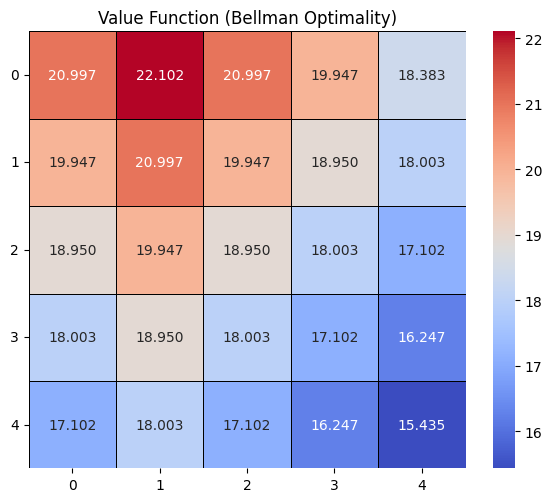

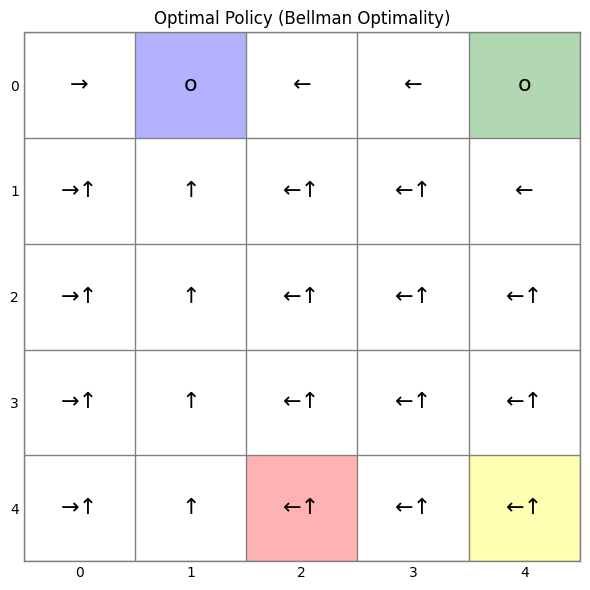

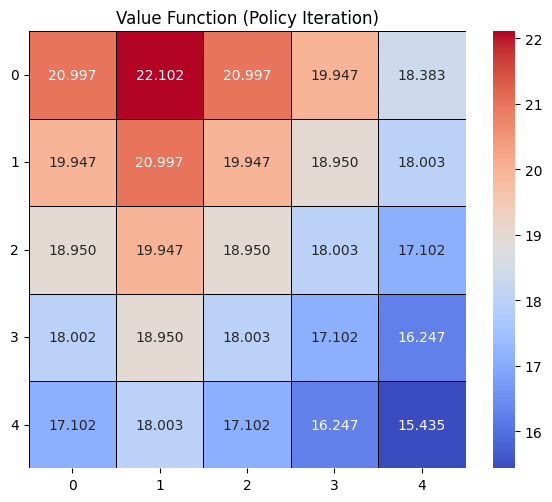

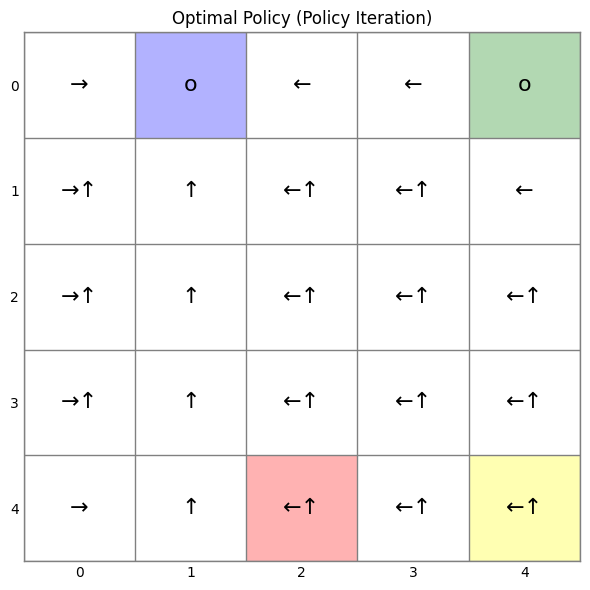

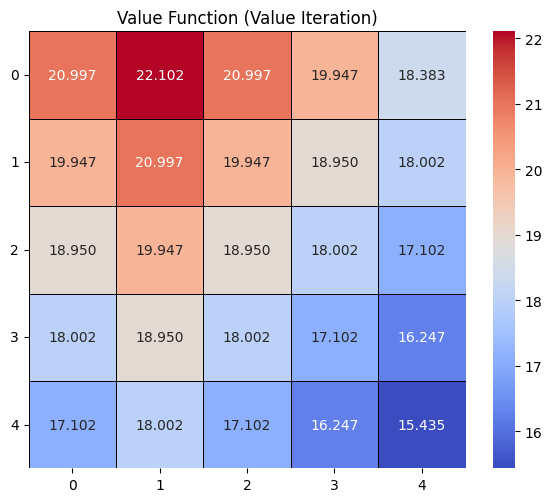

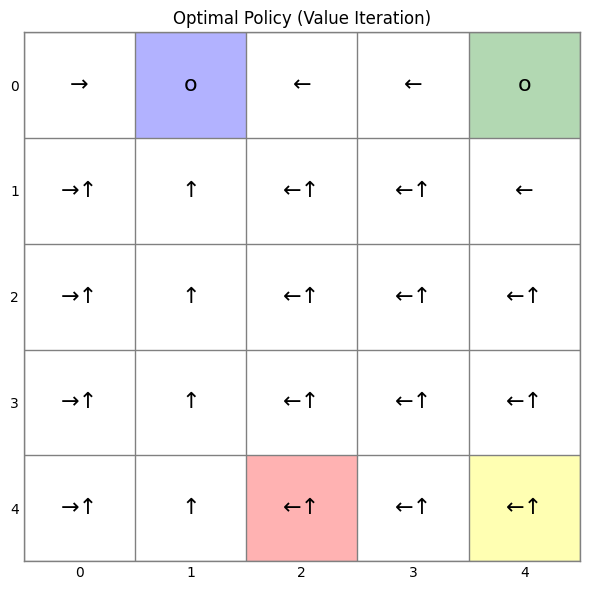

In [13]:
# Initialize the environment, set up parameters
the = 1e-4
gam = 0.95
Env = ENV()

N = Env.number_of_rows

# Calculate the value function and find the optimal policy via the three approaches
V_opt_1, pol_opt_1 = Bellman_opti_equa(gam, Env)
V_opt_2, pol_opt_2 = Policy_iter_with_Iter_policy_eval(the, gam, Env)
V_opt_3, pol_opt_3 = Policy_improvement_with_Value_iter(the, gam, Env)

# Round the value function
V_opt_1_ = np.round(V_opt_1,3)
V_opt_2_ = np.round(V_opt_2,3)
V_opt_3_ = np.round(V_opt_3,3)

# Find the policy again
pol_opt_1_ = find_policy(gam, V_opt_1_, Env)
pol_opt_2_ = find_policy(gam, V_opt_2_, Env)
pol_opt_3_ = find_policy(gam, V_opt_3_, Env)


# Plot Symbolic Policies using print_policy
policy_symbols_1 = np.array(print_policy(pol_opt_1_, Env)).reshape(N, N)
policy_symbols_2 = np.array(print_policy(pol_opt_2_, Env)).reshape(N, N)
policy_symbols_3 = np.array(print_policy(pol_opt_3_, Env)).reshape(N, N)

# Plot Value Function Grids
plot_value_function(V_opt_1_, N, title="Value Function (Bellman Optimality)")
plot_symbolic_policy_from_symbols(policy_symbols_1, title="Optimal Policy (Bellman Optimality)")


plot_value_function(V_opt_2_, N, title="Value Function (Policy Iteration)")
plot_symbolic_policy_from_symbols(policy_symbols_2, title="Optimal Policy (Policy Iteration)")


plot_value_function(V_opt_3_, N, title="Value Function (Value Iteration)")
plot_symbolic_policy_from_symbols(policy_symbols_3, title="Optimal Policy (Value Iteration)")